In [7]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.convolution import convolve
import os

from astroduet.config import Telescope
from astroduet.utils import duet_abmag_to_fluence, duet_fluence_to_abmag
from astroduet.image_utils import find, ap_phot, run_daophot

duet = Telescope()
datadir = os.path.join(os.getcwd(), '../astroduet/data')

read_noise = 3.
exposure = 300 * u.s

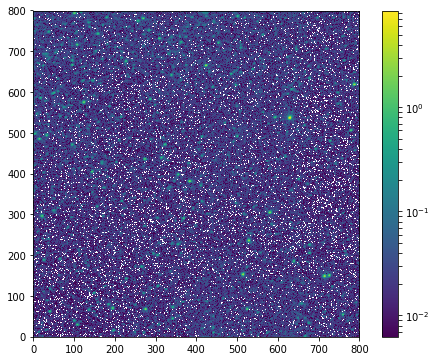

In [31]:
# Load a GALEX LMC/SMC image
galex_lmc_file = fits.open(datadir+'/LMC_CORE_44-nd-int.fits')
galex_lmc_image = galex_lmc_file[0].data
galex_lmc_file.close()

# Grab a square slice from within the image, make a nice 800x800 square to work with
galex_lmc_image = galex_lmc_image[1400:2200,1400:2200]

from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
plt.imshow(galex_lmc_image, cmap='viridis', aspect=1, origin='lower', norm=LogNorm())
plt.colorbar()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


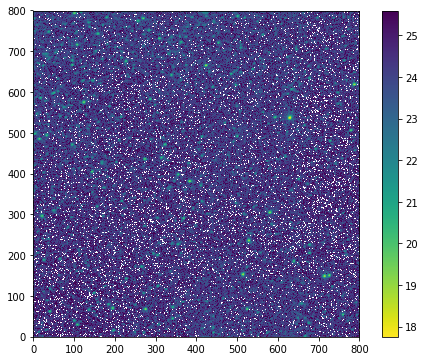

In [32]:
# Convert GALEX count rates to AB magnitude per pixel
# From https://asd.gsfc.nasa.gov/archive/galex/FAQ/counts_background.html
#FUV: mAB = -2.5 x log10(CPS) + 18.82
nuv_zp = 20.08 
nuv_ab = (-2.5 * np.log10(galex_lmc_image) + nuv_zp) * u.ABmag

plt.figure(figsize=(8,6))
plt.imshow(nuv_ab.value, cmap='viridis_r', aspect=1, origin='lower')
plt.colorbar()

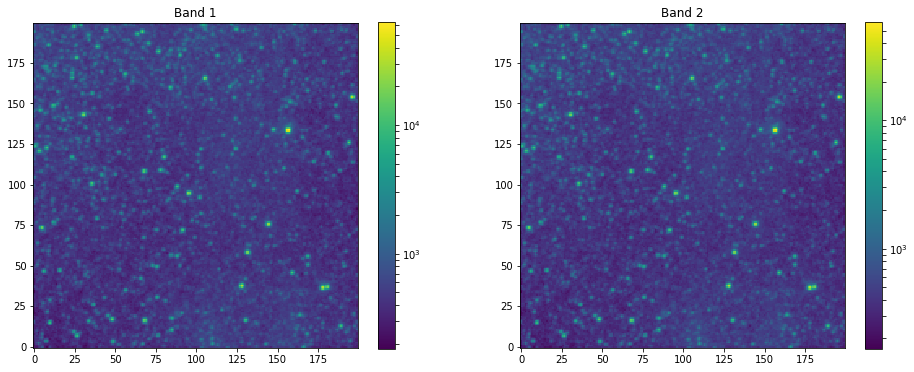

In [34]:
# Pass through Marianne's code to get DUET magnitudes per pixel
# Only really applies to fields with NUV and FUV, and we only have NUV of the most crowded fields
# So let's skip this step for now...

# Convert AB magnitudes back to DUET count rates using utils
fluence1 = duet_abmag_to_fluence(nuv_ab, duet.bandpass1)
fluence2 = duet_abmag_to_fluence(nuv_ab, duet.bandpass2)

duet_countrate1 = duet.trans_eff * duet.eff_area * fluence1
duet_countrate2 = duet.trans_eff * duet.eff_area * fluence2

# Convolve with the PSF, with pixel size equal to GALEX
galex_pixel_size = 1.5 * u.arcsec
psf_kernel = duet.psf_model(pixel_size = galex_pixel_size)
psf_image1 = convolve(duet_countrate1, psf_kernel) * duet_countrate1.unit
psf_image2 = convolve(duet_countrate2, psf_kernel) * duet_countrate2.unit

# Bin up by four to approximate DUET pixel size
shape = (galex_lmc_image.shape[0] // 4, 4, galex_lmc_image.shape[1] // 4, 4)
binned_image1 = psf_image1.reshape(shape).sum(-1).sum(1)
binned_image2 = psf_image2.reshape(shape).sum(-1).sum(1)

# Convert to counts and add noise
counts1 = binned_image1 * exposure
counts2 = binned_image2 * exposure

noise1 = np.random.poisson(counts1.value) + np.random.normal(loc=0,scale=read_noise,size=counts1.shape)
duet_image1 = np.floor(noise1) * counts1.unit
duet_image1[duet_image1 < 0] = 0

noise2 = np.random.poisson(counts2.value) + np.random.normal(loc=0,scale=read_noise,size=counts2.shape)
duet_image2 = np.floor(noise2) * counts2.unit
duet_image2[duet_image2 < 0] = 0

# Number of exposures for a reference image
n_exp = 5

ref1, ref2 = np.zeros(counts1.shape) * counts1.unit, np.zeros(counts2.shape) * counts2.unit
for i in range(n_exp):
    # Apply Poisson noise and instrument noise
    r1 = np.random.poisson(counts1.value) + np.random.normal(loc=0,scale=read_noise,size=counts1.shape)
    r1 = np.floor(r1) * counts1.unit
    r1[r1 < 0] = 0
    
    r2 = np.random.poisson(counts2.value) + np.random.normal(loc=0,scale=read_noise,size=counts2.shape)
    r2 = np.floor(r2) * counts2.unit
    r2[r2 < 0] = 0

    # Add to the co-add
    ref1 += r1
    ref2 += r2
ref_rate1 = ref1 / (exposure * n_exp)
ref_rate2 = ref2 / (exposure * n_exp)

# To-do - multiple exposures to represent reference image
    
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title('Band 1')
plt.imshow(duet_image1.value, cmap='viridis', aspect=1, origin='lower', norm=LogNorm())
plt.colorbar()
plt.subplot(122)
plt.title('Band 2')
plt.imshow(duet_image2.value, cmap='viridis', aspect=1, origin='lower', norm=LogNorm())
plt.colorbar()

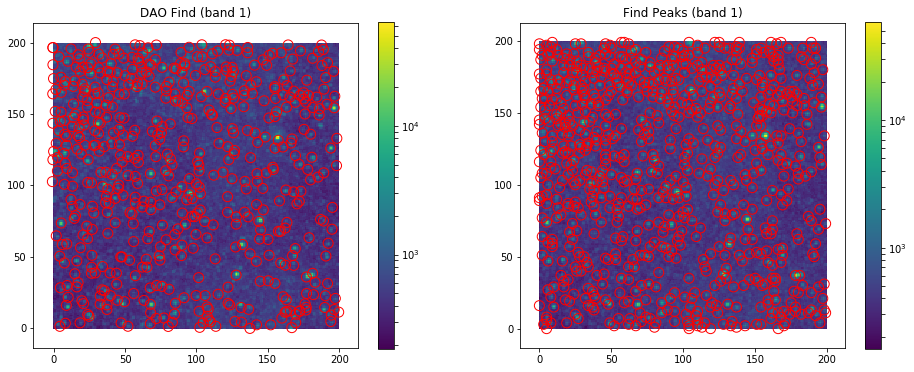

In [11]:
# Run source finding
psf_fwhm = duet.calc_psf_fwhm() 
psf_fwhm_pix = psf_fwhm / duet.pixel

star_tbl_daophot1, _, threshold1 = find(duet_image1.value,psf_fwhm_pix.value,method='daophot')
star_tbl_peaks1, _, _ = find(duet_image1.value,psf_fwhm_pix.value,method='peaks')

star_tbl_daophot2, _, threshold2 = find(duet_image2.value,psf_fwhm_pix.value,method='daophot')

# Note - background estimation is being done from the image itself 
# so naturally this is not going to find faint stars on a first pass

# Plot
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title('DAO Find (band 1)')
plt.imshow(duet_image1.value, cmap='viridis', aspect=1, origin='lower', norm=LogNorm())
plt.colorbar()
plt.scatter(star_tbl_daophot1['x'],star_tbl_daophot1['y'],marker='o',s=100,facecolors='none',edgecolors='r',lw=1)
plt.subplot(122)
plt.title('Find Peaks (band 1)')
plt.imshow(duet_image2.value, cmap='viridis', aspect=1, origin='lower', norm=LogNorm())
plt.colorbar()
plt.scatter(star_tbl_peaks1['x'],star_tbl_peaks1['y'],marker='o',s=100,facecolors='none',edgecolors='r',lw=1)

In [12]:
# Photometry using DAOPhot

# Convert to count rate
duet_image_rate1, duet_image_rate2 = duet_image1 / exposure, duet_image2 / exposure

# Run PSF-fitting photometry
result1, residual_image1 = run_daophot(duet_image_rate1.value,threshold1,star_tbl_daophot1,niters=1,duet=duet)
result2, residual_image2 = run_daophot(duet_image_rate2.value,threshold2,star_tbl_daophot2,niters=1,duet=duet)

print("Band 1: {} sources found. Band 2: {} sources found.".format(len(result1),len(result2)))

#print(result1['x_fit','y_fit','flux_fit','flux_unc'])
#print(result2['x_fit','y_fit','flux_fit','flux_unc'])


PSF-fitting complete


PSF-fitting complete
Band 1: 548 sources found. Band 2: 561 sources found.


(-10, 210)

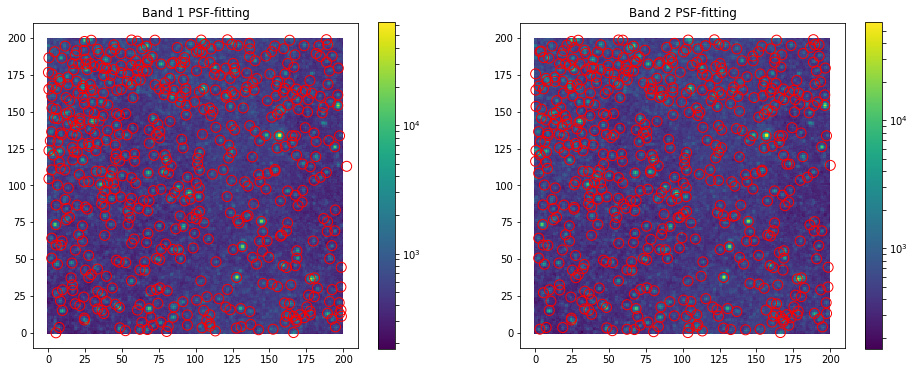

In [13]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title('Band 1 PSF-fitting')
plt.imshow(duet_image_rate1.value, cmap='viridis', aspect=1, origin='lower', norm=LogNorm())
plt.colorbar()
plt.scatter(result1['x_fit'],result1['y_fit'],marker='o',s=100,facecolors='none',edgecolors='r',lw=1)
plt.xlim(-10,210)
plt.ylim(-10,210)
plt.subplot(122)
plt.title('Band 2 PSF-fitting')
plt.imshow(duet_image_rate2.value, cmap='viridis', aspect=1, origin='lower', norm=LogNorm())
plt.colorbar()
plt.scatter(result2['x_fit'],result2['y_fit'],marker='o',s=100,facecolors='none',edgecolors='r',lw=1)
plt.xlim(-10,210)
plt.ylim(-10,210)

In [24]:
# Count rates to fluences to magnitudes
duet_fluences1 = result1['flux_fit'] * duet_image_rate1.unit / (duet.trans_eff * duet.eff_area)
duet_mag1 = duet_fluence_to_abmag(duet_fluences1,duet.bandpass1)

duet_fluences2 = result2['flux_fit'] * duet_image_rate2.unit / (duet.trans_eff * duet.eff_area)
duet_mag2 = duet_fluence_to_abmag(duet_fluences2,duet.bandpass2)

/anaconda3/lib/python3.6/site-packages/astropy/units/function/logarithmic.py:43: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


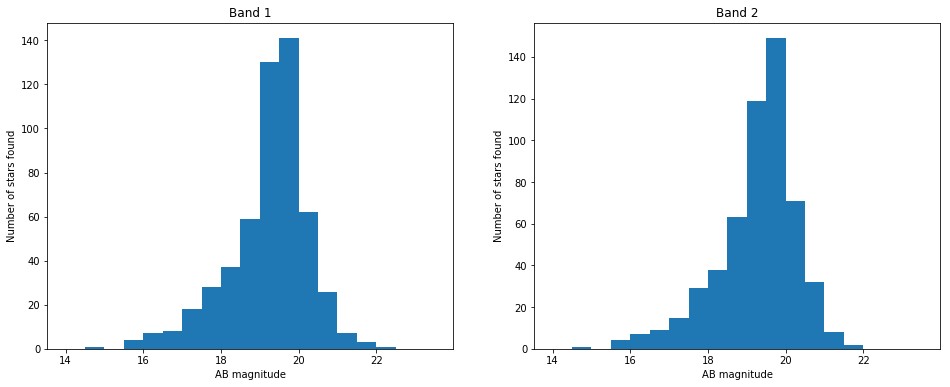

In [28]:
# Plot histogram of sources found
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.xlabel('AB magnitude')
plt.ylabel('Number of stars found')
plt.title('Band 1')
plt.hist(duet_mag1, bins=np.arange(14,24,0.5), range=(14,24))
plt.subplot(122)
plt.xlabel('AB magnitude')
plt.ylabel('Number of stars found')
plt.title('Band 2')
plt.hist(duet_mag2, bins=np.arange(14,24,0.5), range=(14,24))
plt.show()

PSF-fitting complete


PSF-fitting complete
5 exposures. Band 1: 602 sources found. Band 2: 578 sources found.


/anaconda3/lib/python3.6/site-packages/astropy/units/function/logarithmic.py:43: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


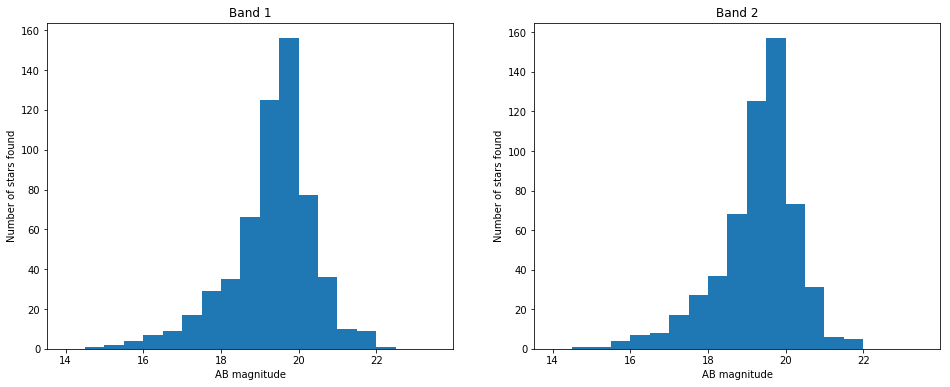

In [35]:
# Does this change for a 'reference image'?
ref_tbl1, _, threshold1 = find(ref_rate1.value,psf_fwhm_pix.value,method='daophot')
ref_tbl2, _, threshold2 = find(ref_rate2.value,psf_fwhm_pix.value,method='daophot')

ref_result1, _ = run_daophot(ref_rate1.value,threshold1,ref_tbl1,niters=1,duet=duet)
ref_result2, _ = run_daophot(ref_rate2.value,threshold2,ref_tbl2,niters=1,duet=duet)

ref_fluences1 = ref_result1['flux_fit'] * ref_rate1.unit / (duet.trans_eff * duet.eff_area)
ref_mag1 = duet_fluence_to_abmag(ref_fluences1,duet.bandpass1)

ref_fluences2 = ref_result2['flux_fit'] * ref_rate2.unit / (duet.trans_eff * duet.eff_area)
ref_mag2 = duet_fluence_to_abmag(ref_fluences2,duet.bandpass2)

print("{} exposures. Band 1: {} sources found. Band 2: {} sources found.".format(n_exp, len(ref_result1), len(ref_result2)))

# Plot histogram of sources found
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.xlabel('AB magnitude')
plt.ylabel('Number of stars found')
plt.title('Band 1')
plt.hist(ref_mag1, bins=np.arange(14,24,0.5), range=(14,24))
plt.subplot(122)
plt.xlabel('AB magnitude')
plt.ylabel('Number of stars found')
plt.title('Band 2')
plt.hist(ref_mag2, bins=np.arange(14,24,0.5), range=(14,24))
plt.show()

In [ ]:
# Next, insert fake varying stars and retrieve as before

In [ ]:
'''
    In progress - trying to figure out how to build a fittable PSF like the DUET one

    # astropy fittable model based on the two Gaussians. Possibly this should go in config?
    sig = duet.psf_params['sig']
    amp = duet.psf_params['amp']
    
    duet_psf = duet.psf_model()
    
    psf_model = IntegratedGaussianPRF(flux=flux1, sigma=sig[0]) + IntegratedGaussianPRF(flux=flux2, sigma=sig[1])
   
    print(star_tbl.columns)
    
'''